In [2]:
%matplotlib inline
%config InlineBackend.figure_format='png'
import pylab as pl
import numpy as np
import scipy.signal as signal
import matplotlib as mpl
mpl.rcParams['axes.grid'] = True
import matplotlib.ticker as ptick 

## CWモードのためのフィルタ設計

CentSDR用に狭帯域モードを用意する

#### 方針と仕様

300Hz帯域とするため、0Hzを中心とした正負対称で150HzカットオフのLPFを設計する。

* サンプリングレート48000Hzにてfc=150Hzの6次IIRローパスフィルタ
* 楕円(ellipitic)フィルタで、リプル1dB, 阻止量40dBとする
* scipy.signalに用意されているフィルタ設計関数を用いて設計する

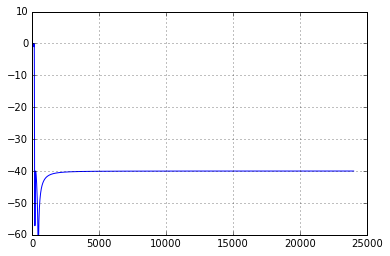

In [13]:
bb, aa = signal.ellip(6, 1, 40, 150.0/24000, 'low')
w,h = signal.freqz(bb, aa, worN=4096)
w = w * 48000 / (2 *np.pi)
pl.ylim((-60, 10))
pl.plot(w, 20 * np.log10(abs(h)));

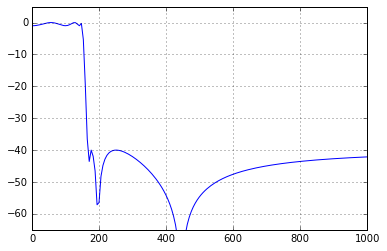

In [12]:
pl.xlim(0, 1000)
pl.ylim((-65, 5))
pl.plot(w, 20 * np.log10(abs(h)));

(array([ 0.00099325, -0.00595041,  0.0148624 , -0.01981048,  0.0148624 ,
        -0.00595041,  0.00099325]),
 array([  1.        ,  -5.98127859,  14.9072007 , -19.81600654,
         14.81760149,  -5.90959322,   0.98207615]))

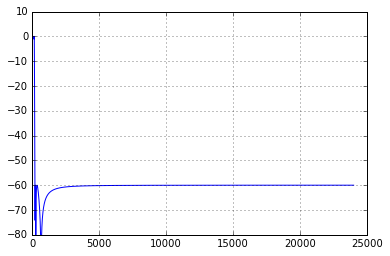

In [20]:
bb, aa = signal.ellip(6, 1, 60, 150.0/24000, 'low')
w,h = signal.freqz(bb, aa, worN=4096)
w = w * 48000 / (2 *np.pi)
pl.ylim((-80, 10))
pl.plot(w, 20 * np.log10(abs(h)));
bb,aa

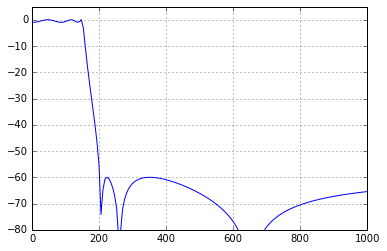

In [21]:
pl.xlim(0, 1000)
pl.ylim((-80, 5))
pl.plot(w, 20 * np.log10(abs(h)));

### 双二次(biquad)に分解

特性を確認できたら、つづいて実装のための係数を求める。

実装では2次フィルタを直列にカスケードする。そのため6次フィルタを3つの2次フィルタに分解することを考える。具体的にはba形式(多項式の係数)で表現された伝達関数(6次式)を、3つの2次式の積に因数分解することになる。しかし、多項式に展開済みの伝達関数の分解は容易ではないので、分解が容易になるようzpk形式という零点と極の位置とゲインで表現した形式で再設計してみる。

In [22]:
z, p, k = signal.ellip(6, 1, 60, 150.0/24000, 'low', output='zpk')
z,p,k

(array([ 0.99636455+0.085192j  ,  0.99941981+0.03405942j,
         0.99963570+0.02699014j,  0.99636455-0.085192j  ,
         0.99941981-0.03405942j,  0.99963570-0.02699014j]),
 array([ 0.99466326-0.00641379j,  0.99697235-0.01572576j,
         0.99900368-0.01956282j,  0.99466326+0.00641379j,
         0.99697235+0.01572576j,  0.99900368+0.01956282j]),
 0.0009932518091724748)

ちなみにzpk2tf関数を使うと、zpk形式を伝達関数の係数形式に変換できる。

In [23]:
signal.zpk2tf(z, p, k)

(array([ 0.00099325, -0.00595041,  0.0148624 , -0.01981048,  0.0148624 ,
        -0.00595041,  0.00099325]),
 array([  1.        ,  -5.98127859,  14.9072007 , -19.81600654,
         14.81760149,  -5.90959322,   0.98207615]))

### 順序を決定

2次フィルタを構成するために、共役な零点zのペアと極pのペアをそれぞれ選択する。共役なzとpは3個毎に並んでいるようなので、それらをペアにして、それぞれ個別に組み合わせて伝達関数を計算する。それらを重ねてプロットし、検討する。

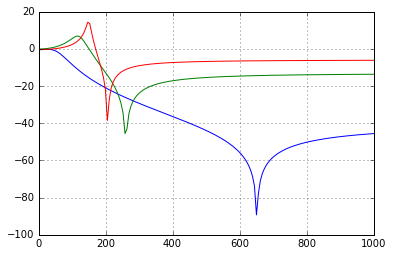

In [26]:
def plot_biquad(n, m, kk=k):
    bb, aa = signal.zpk2tf(z[n::3], p[m::3], kk)
    w,h = signal.freqz(bb, aa, worN=4096)
    w = w * 48000 / (2 *np.pi)
    pl.ylim((-100, 20))
    pl.xlim((0, 1000))
    pl.plot(w, 20 * np.log10(abs(h)));
    return bb, aa
b0,a0 = plot_biquad(0, 0, k**0.68)
b1,a1 = plot_biquad(1, 1, k**0.22)
b2,a2 = plot_biquad(2, 2, k**0.1)

オーバーフローが発生しないよう、ゲインを適切に配分し、フィルタの順序を決定する。この例では青、緑、赤の順に適用する。ピークが生じる部分でオーバーフローさせないよう、先に減衰させるような順序としている。

得られた3つの伝達関数の係数を確認してみる

In [27]:
print b0, a0
print b1, a1
print b2, a2

[ 0.00907821 -0.01809042  0.00907821] [ 1.         -1.98932652  0.98939613]
[ 0.21845051 -0.43664753  0.21845051] [ 1.         -1.99394471  0.99420117]
[ 0.50084799 -1.00133107  0.50084799] [ 1.         -1.99800737  0.99839106]


### CMSIS-DSPLIB用に係数を変換

IIRフィルタの実装は、CMSIS_DSPLIBで提供されているarm_biquad_cascade_df1_q15関数を用いる。その仕様に合わせて各係数を16ビット固定小数点の整数値に変換する。1を越えている係数があるので、16ビットに納まるよう1ビット右シフトした数値とするため32768>>1=16384を乗じ、数値を整数に丸める。

In [28]:
print np.rint(b0*16384),np.rint(a0*16384)
print np.rint(b1*16384),np.rint(a1*16384)
print np.rint(b2*16384),np.rint(a2*16384)

[ 149. -296.  149.] [ 16384. -32593.  16210.]
[ 3579. -7154.  3579.] [ 16384. -32669.  16289.]
[  8206. -16406.   8206.] [ 16384. -32735.  16358.]


### コード用に整形

arm_biquad_cascade_df1_q15関数に使用する係数は、並べ方に注意する必要があるのと、定義の違いによりaの符号が反対であることに注意する必要がある。詳しくはリファレンス(1)を参照のこと。

(1)http://www.keil.com/pack/doc/CMSIS/DSP/html/group___biquad_cascade_d_f1.html

In [41]:
def bq(b, a):
    b, a = np.rint(b*16384), np.rint(a*16384)
    print "\t" + "".join(["%d, "%v for v in [b[0], 0, b[1], b[2], -a[1], -a[2]]])
print "q15_t bq_coeffs[] = {"
bq(b0, a0)
bq(b1, a1)
bq(b2, a2)
print "};"

q15_t bq_coeffs[] = {
	149, 0, -296, 149, 32593, -16210, 
	3579, 0, -7154, 3579, 32669, -16289, 
	8206, 0, -16406, 8206, 32735, -16358, 
};


### 完成